# EPSRC: AI Skills Through Music 🤖🎹

In [325]:
!pip install mirdata -q -q

import IPython.display as ipd
import mirdata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import seaborn as sns
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

np.set_printoptions(suppress=True)

## 2: Learning Paradigms 🧠

Watch the video below. *How many instruments can you identify?* What qualities are you listening out for?

In [ ]:
ipd.HTML('''
<iframe width="560" height="315"
src="https://www.youtube.com/embed/tb0gHAzpQPE"
referrerpolicy="strict-origin-when-cross-origin"
</iframe>
''')

A machine learning model that can perform the same task would have a number of powerful use cases. For instance, it could *automatically label instruments* in a music library, help musicians *organise or search for recordings* by instrument, or assist in creating *educational tools*.

In this notebook, we're going to explore ways of training machine learning models to **identify instruments** in an audio recording. In particular, we'll consider two of the main ways in which we can "teach" a model:

1. **Unsupervised Learning**: like learning by finding patterns on your own, without specific instructions.
2. **Supervised Learning**: like learning from a teacher, who gives you examples and corrections.

By the end of the notebook, we'll have trained a machine learning model to identify **14 different musical instruments** from audio recordings. You can then apply this model to your own recordings!

## Data 🔢

To train our models, we're going to need some data. Ideally, our dataset should have the following:

- A **large number** of audio recordings;
- made on **different musical instruments;**
- with a variety of different **acoustic qualities** (playing styles, volume levels, etc.)
- available under a **permissive license** that allows for training machine learning models with non-commercial applications

There are many possible datasets that we could use to accomplish this task. We could look on popular websites like [`kaggle`](https://www.kaggle.com/) or [`huggingface`](https://huggingface.co/), for instance.

### TinySOL 🌞

One dataset that fits our needs is the `TinySOL` dataset. This contains 2913 musical notes recorded from 14 different musical instruments. The instruments are:

1. Tuba 📯
2. French Horn 📯
3. Trombone 🎺
4. Trumpet 🎺
5. Accordion 🎹
6. Double bass 🎻
7. Violin 🎻
8. Viola 🎻
9. Cello 🎻
10. Bassoon 🪈
11. Clarinet 🪈
12. Flute 🪈
13. Oboe 🪈
14. Saxophone 🎷

TinySOL is released under a **CC-BY-4.0 license**. This means that it can be reused **by anyone and for any purpose**, on the condition that the creator is appropriately credited.

For more information on TinySOL and how it was created, [check out this website.](https://zenodo.org/records/3685331)

### MIRData 🎹

In order to work with TinySOL in Python, we're going to use the [`mirdata`](https://github.com/mir-dataset-loaders/mirdata) library. This will allow us to download the dataset and load its audio files. It will also allow us to *validate* the dataset, to make sure that we have all the correct files and that nothing is corrupt.

Note that TinySOL is quite large (**1 gigabyte**). Depending on the internet connection, *it may take a while to download*, so please be patient!

In [5]:
tinysol = mirdata.initialize('tinysol')
tinysol.download()

979MB [04:55, 3.47MB/s]                           
312kB [00:01, 192kB/s]                           
488kB [00:01, 349kB/s]                           


In [6]:
tinysol.validate()

100%|██████████| 2913/2913 [00:05<00:00, 486.28it/s]


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

Great! We've downloaded TinySOL and confirmed that the dataset is valid and complete. Let's take a listen to one of the audio files:

In [11]:
track = tinysol.choice_track()
y, sr = track.audio
ipd.Audio(y, rate=sr)

Note that TinySOL was recorded with a *sample rate* of 44,100 Hz. If you're not sure what this means, check out the previous notebook on **Data Representations**.

## Feature Engineering

In the **Data Representations** notebook, we looked at ways extract low-level summary statistics (**features**) from an audio signal. We can use these features to train our model to **identify instruments**.

### Spectrogram

Before we can extract these features, we need to represent our audio with a **spectrogram**. As a reminder, a spectrogram uses *short-time Fourier transforms* (STFTs) to express the time, amplitude, and frequency of an audio signal as a two dimensional matrix.

Let's look at a spectrogram extracted from our audio signal:

In [14]:
X_stft = np.abs(librosa.stft(y, win_length=512, hop_length=256))
spect = librosa.amplitude_to_db(X_stft)

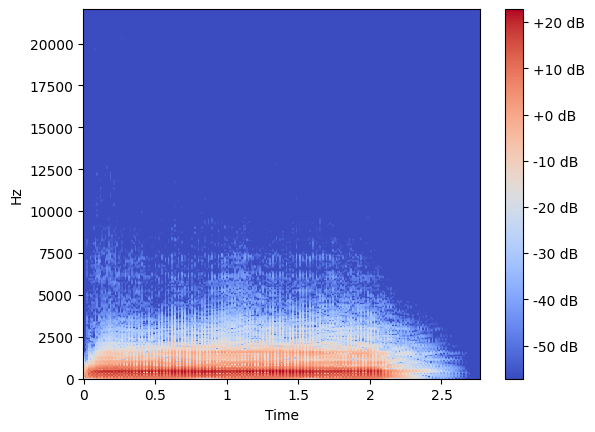

In [15]:
librosa.display.specshow(spect, sr=sr, x_axis="time", y_axis="linear")
plt.colorbar(format="%+2.0f dB")
plt.show()

### Feature Extraction

In the **Data Representations** notebook, we explored two types of **temporal feature**:
1. **spectral centroid**: the average frequency of every **column** in the spectrogram
2. **spectral bandwidth**: the standard deviation of every **column** in the spectrogram

Alongside these features, we can also consider several more:

3. **spectral flatness**: measures how "noisy" a sound is: high flatness means the sound is noiser, low flatness means its more like a single note
4. **spectral rolloff**: the frequency below which most of the signal’s energy is concentrated (usually 85%); it helps show whether a sound is "bright" (more high frequencies) or "dark" (mostly low frequencies).
5. **root-mean-square**: measures the average loudness of a sound over time: a whisper has a low RMS, while a shout has a high RMS
6. **zero-crossing rate**: the fraction of samples in a frame that cross 0, usually higher for noisy or percussive sounds

For exact mathematical definitions of these features, refer to the [`librosa` documentation](https://librosa.org/doc/main/feature.html)

We're going to define a Python **function** that does the following:

1. Converts an audio waveform into a magnitude spectrogram
2. Extracts the **six features** described above from every frame
3. Stacks these features into a matrix with shape `(N_frames, N_features)`. In other words, every **row** is a frame, and every **column** is a feature

We'll use a frame size of 512 samples and a hop of 256. This means that we'll compute the FFT from samples `0:512`, then `256:768`, then `512:1024`, and so on until we run out of audio.


In [41]:
def feature_extractor(waveform: np.ndarray, sr: float) -> np.ndarray:
    """
    Extracts temporal features from an audio signal.

    Returns a 2D array, where each row is a frame and each column is a feature
    """
    # Compute the spectrogram
    X_stft = librosa.stft(waveform, win_length=512, hop_length=256)
    spect = np.abs(librosa.amplitude_to_db(np.abs(X_stft)))

    # Extract every feature
    spectral_centroids = librosa.feature.spectral_centroid(S=spect,)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(S=spect,)
    spectral_flatness = librosa.feature.spectral_flatness(S=spect,)
    spectral_rolloff = librosa.feature.spectral_rolloff(S=spect,)
    rmse = librosa.feature.rms(S=spect,)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(waveform, frame_length=512, hop_length=256)

    # Stack the features to the shape (N_frames, N_features)
    return np.vstack([
        spectral_centroids,
        spectral_bandwidth,
        spectral_flatness,
        spectral_rolloff,
        rmse,
        zero_crossing_rate,
    ]).T


extracted = feature_extractor(y, sr)


(239, 6)


Let's check the shape of the feature matrix:

In [53]:
print(extracted.shape)

(1185, 6)


Great! We can see that our audio recording has 239 frames. For every frame, we've extracted 6 **spectral features**.


#### Frames or Recordings? 🖼

While we could train our model on data extracted from every **frame**, there might be some problems with this:

- Given that each frame lasts a very short amount of time (around 0.01 second!), we might expect successive frames to contain **very similar information**;
- Some frames might not contain audio: for example, if the musician stopped playing **before the recording ended**. These frames could confuse a model.

Because of these reasons, we can instead **average** every feature for a single recording. To do this, we can simply use `numpy`:

In [42]:
extracted_vector = np.mean(extracted, axis=0)
print(extracted_vector.shape)

(6,)


We now have a **feature vector**: a one-dimensional vector with shape `(N_features,)`. Let's print this out:

In [43]:
print(extracted_vector.round(3))

[6089.234 2897.038    0.763 9560.607    1.163    0.029]


### Data Pipeline 🗒

We can now proceed to define our complete **data pipeline**. This needs to do the following:

1. Load an audio file from TinySOL
2. Extract the six spectral features from every frame to create a matrix with shape `(N_frames, N_features)`
3. Average every feature over each frame to create a vector of shape `(N_features,)`
4. Stack this vector for every recording to create a matrix with shape `(N_recordings, N_features)`

Run the cell below to extract features from all the recordings in `tinysol`. Note that this may take a while (~10 minutes), *so please be patient!*

In [52]:
# Load up all the recordings from tinysol
all_recordings = tinysol.load_tracks()
# Initialise an empty list to store all the feature vectors
all_features = []

# Iterate over all the recordings. We use `tqdm` to create the progress bar
for key, track in tqdm(all_recordings.items(), desc="Extracting features..."):
    # Get the audio and the sample rate
    y, sr = track.audio
    # Extract the features for every frame: shape (N_frames, N_features)
    extracted = feature_extractor(y, sr)
    # Average the features over all frames to create a vector: shape (N_features,)
    extracted_vector = np.mean(extracted, axis=0)
    all_features.append(extracted_vector)

# Stack all of the vectors into a matrix with shape (N_recordings, N_features)
feature_matrix = np.array(all_features)

Extracting features...: 100%|██████████| 2913/2913 [08:47<00:00,  5.52it/s]


Great! We can confirm that our pipeline worked correctly by looking at the *shape of the feature matrix*:

In [55]:
print(feature_matrix.shape)

(2913, 6)


This shows we have 2913 recordings, the same number as in TinySOL. For each of these recordings, we have 6 features.

#### Visualising Feature Distributions

Let's start taking a closer look at some of our features. To do so, we can create **histograms** for the distribution of values for a feature.

For now, we'll just visualise the spectral centroid and zero-crossing rate. We'll use the `seaborn ` library to create these plots.

> We can also add to these histograms with **kernel density estimates (KDE)**. Think of the KDE as a bit like a *smoothed histogram*. It transforms the distribution of values obtained for a feature, across all recordings, into a one-dimensional, continuous-valued sequence.

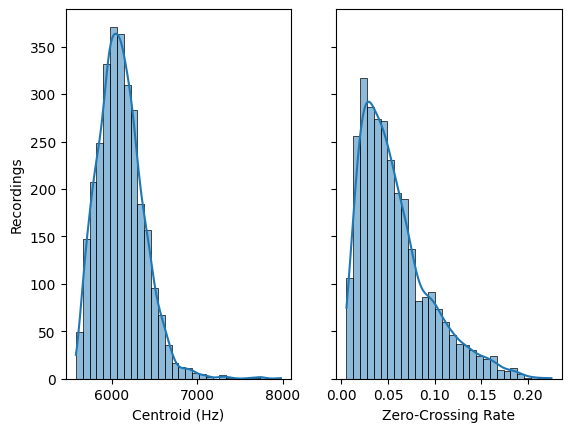

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)

sns.histplot(feature_matrix[:, 0], kde=True, ax=ax[0], bins=30)
sns.histplot(feature_matrix[:, 5], kde=True, ax=ax[1], bins=30)

ax[0].set(xlabel="Centroid (Hz)", ylabel="Recordings")
ax[1].set(xlabel="Zero-Crossing Rate", ylabel="")

plt.show()

We can notice a few things about these plots:
- Both distributions are **right-tailed** (positive skew). This means that the majority of values are on the *left* of the plot, but that it has a long *right* tail (extreme positive values).
- The tail for the Zero-Crossing Rate variable is wider than that of Spectral Centroid

What else do you notice about these plots?

### Pre-Processing

Something else we can see from looking at the distributions is that the minimum and maximum values of the spectral centroid variable is **much larger** than that obtained for the zero-crossing rate.

This is because the spectral centroid will range between 0 Hz and the highest frequency that can be measured in a recording. Meanwhile, the zero-crossing rate is measured as a fraction of total samples in the frame, and thus will range between 0 and 1.

> **Did you know?** The highest measurable frequency in an audio recording is called the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency). It is equivalent to half the sampling rate (i.e., 22,050 Hz, for the recordings in TinySOL).

If we were to train our model directly on the raw data we've extracted, **it might take a very long time to learn anything** because of the differences in range between the features.

To prevent this from happening, machine learning scientists usually **normalise** or **standardise** their features.

#### Normalisation

Normalisation means to adjust values measured on diferent scales to a *common scale*. There are many different types of normalisation, including:

- *Min-max normalisation*: this involves rescaling the values for a feature to between 0 and 1. We assign 0 to the smallest value, and 1 to the largest.
- *Mean centering*: this involves subtracting the average value for a feature from every value we have obtained. This **centres** the feature to have a mean of 0.
- *Log normalisation*: this involves applying a **logarithmic transformation** to the feature. This reduces the impact of very large values and spreads out smaller values, which can help when we have extreme outliers.

Let's apply these types of transformation to our spectral centroid, and show how the distribution changes.

In [83]:
# Get just the values for the spectral centroid feature
spectral_centroids = feature_matrix[:, 0]

# Min-Max scaling
min_centroid = spectral_centroids.min()
max_centroid = spectral_centroids.max()
centroid_minmax = (spectral_centroids - min_centroid) / (max_centroid - min_centroid)

# Mean scaling
centroid_mean = spectral_centroids - np.mean(spectral_centroids)

# Log scaling (we'll use a base 2 transformation)
centroid_log = np.log2(spectral_centroids)

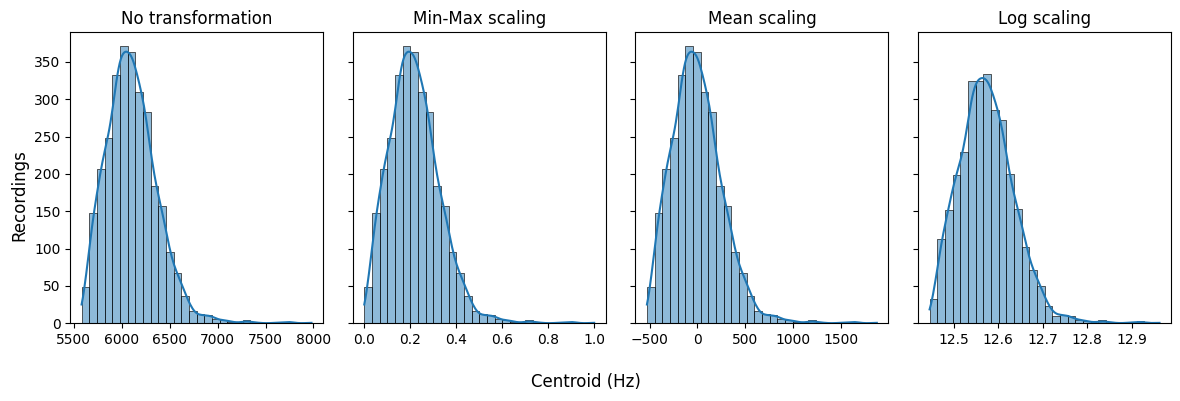

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=True, figsize=(12, 4))

sns.histplot(spectral_centroids, kde=True, ax=ax[0], bins=30)
sns.histplot(centroid_minmax, kde=True, ax=ax[1], bins=30)
sns.histplot(centroid_mean, kde=True, ax=ax[2], bins=30)
sns.histplot(centroid_log, kde=True, ax=ax[3], bins=30)

ax[0].set(title="No transformation", ylabel="")
ax[1].set(title="Min-Max scaling", ylabel="")
ax[2].set(title="Mean scaling", ylabel="")
ax[3].set(title="Log scaling", ylabel="")

fig.supylabel("Recordings")
fig.supxlabel("Centroid (Hz)")
plt.tight_layout()

plt.show()

Notice how each transformation effects the scale of the x-axis differently, but doesn't change the shape of the distribution all that much.

#### Standardisation

While there are many different types of **normalisation**, **standardisation** typically refers to a single process (sometimes called **Z-score standardisation** or simply **Z-scoring**).

This process transforms a feature to have a **mean of 0** and a **standard deviation of 1**.

The formula is very simple:

$Z_X = \dfrac{X - \mu}{\sigma}$

Where $X$ is the value for a feature, $\mu$ is its mean, and $\sigma$ is its standard deviation.

Let's apply **Z-scoring** to our data:

In [85]:
centroids_z = (spectral_centroids - np.mean(spectral_centroids)) / np.std(spectral_centroids)

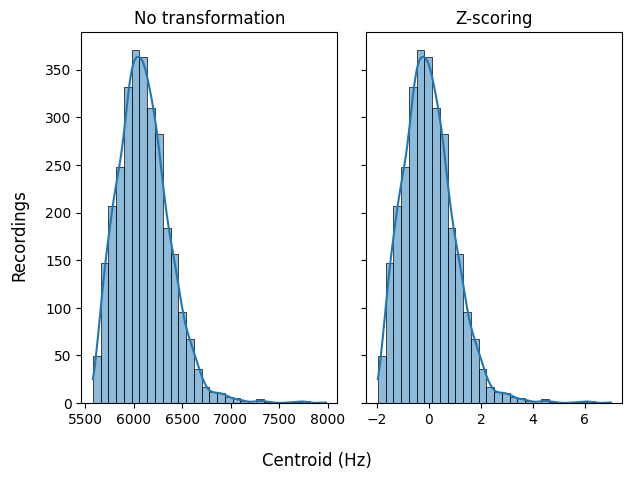

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)
sns.histplot(spectral_centroids, kde=True, ax=ax[0], bins=30)
sns.histplot(centroids_z, kde=True, ax=ax[1], bins=30)

ax[0].set(title="No transformation", ylabel="")
ax[1].set(title="Z-scoring", ylabel="")

fig.supylabel("Recordings")
fig.supxlabel("Centroid (Hz)")
plt.tight_layout()
plt.show()

Notice how applying **standardisation** has centred the data to have a **mean of 0** and scaled it to have a **standard deviation of 1**. We can check this:

In [89]:
print(round(np.mean(centroids_z)))
print(round(np.std(centroids_z)))

0
1


#### Normalisation vs. Standardisation

One of the most common questions asked by students learning feature engineering for machine learning is whether they should normalise or standardise their data. The answer is: ***it depends!***

Normalisation is usually appropriate when using machine learning algorithms that rely on distances between data points, such as **k-Nearest Neighbours (kNN)**. This is to prevent features with larger scales from dominating the distance calculation.

On the other hand, standardisation is appropriate in cases where features vary widely in magnitude and variance. Some machine learning algorithms, including **Support Vector Machines (SVM)**, expect **data to be standardised**.

Machine learning scientists will often experiment with different methods of transforming their feature set before applying their model. For now, as we're mostly concerned with **distance-based models** in this notebook, we'll just use **min-max normalisation**.

Let's write a function to apply it to every feature in our feature set. We'll then use `np.apply_along_axis` to apply this function separately to every column in our feature matrix.

In [200]:
def minmax_norm(feature: np.ndarray) -> np.ndarray:
    """
    Normalises a feature to have min(F) = 0, max(F) = 1
    """
    min_ = feature.min()
    max_ = feature.max()
    return (feature - min_) / (max_ - min_)
    #return (feature - np.mean(feature)) / np.std(feature)


norm_feature_matrix = np.apply_along_axis(minmax_norm, 0, feature_matrix)

Let's check that our normalised matrix has the same shape as the original input:

In [188]:
print(f"Input: {feature_matrix.shape}")
print(f"Output: {norm_feature_matrix.shape}")

Input: (2913, 6)
Output: (2913, 6)


Let's also check that we've normalised each column correctly.

In [98]:
for col in norm_feature_matrix.T:
    print(col.shape, round(col.min(), 3), round(col.max(), 3))

(2913,) 0.0 1.0
(2913,) 0.0 1.0
(2913,) 0.0 1.0
(2913,) 0.0 1.0
(2913,) 0.0 1.0
(2913,) 0.0 1.0


OK, we've now done the following:

1. Downloaded and validated our dataset of musical instrument recordings;
2. Extracted our set of 6 features from every recording;
3. Preprocessed and normalised our features.

Now we're ready to start training some models!

## Unsupervised Learning

The first type of machine learning paradigm we are going to explore is called **unsupervised learning**.

Unsupervised learning is a type of machine learning where the computer looks for patterns in data without being told what the "right answer" is. Instead of labels, it tries to group or organise the data on its own.

For example:
- Identifying patterns in weather data, like seasons or extreme events
- Finding common themes in large sets of text, like news articles or reviews
- Detecting unusual bank transactions that might be fraud

In our case, we're going to use unsupervised learning to **cluster together recordings by the same musical instrument**.


### k-Means Clustering

Clustering models are a type of unsupervised learning that aim to group data into distinct **clusters**.

Consider a social setting where there are groups of people having discussions in different circles around a room. When you first look at the room, you just see a **group of people**. You could mentally start placing points in the **center of each group** of people and name that point as a **unique identifier**. You would then be able to refer to each group **by a unique name** to describe them.

This is essentially what k-means clustering does with data. Mathematically, k-means starts by guessing a few center points (called ***centroids*** - but don't confuse this with our **spectral centroid** feature!!). Each data point is then assigned to the nearest center. The centers are moved to the average position of the points in their group, and this process repeats until the centers stop changing - forming clear, natural clusters.

<img src="https://media.datacamp.com/legacy/v1725630538/image_9c867e067e.png" width="600px"/>

#### Simple k-Means with Two Dimensions

Let's try applying k-Means clustering to our data. To do this, we'll use the implementation in the `sklearn` Python package.

For now, *we're only going to train the model using the spectral centroid and zero-crossing rate features*. This will make visualising the model's predictions a bit easier. Later on, we'll use the full feature space.


In [238]:
model = KMeans(n_clusters=3, random_state=42, n_init="auto")
# Fit the model just to the spectral centroid and zero crossing rate
X = norm_feature_matrix[:, [0, 5]]
model.fit(X)

KMeans(n_clusters=3, random_state=42)

You may have noticed that we provided a variety of parameters to the model.

At the moment, the only one we need to think about is `n_clusters`. This is the **number of clusters** the model should try and find.

Initially, we set this to 3. This is because TinySOL contains both brass 🎺, woodwind 🪈, and stringed 🎻 instruments, so this should prove enough to do some useful clustering.

> *Once you've tried with 3 clusters, why not try re-running the code with a greater number of clusters?*

We can access the cluster assigned to each recording by using the `labels_` attribute of the model.

In [241]:
labels = model.labels_
print(labels.shape)

(2913,)


We can see that we have one label for every recording in TinySOL.

#### Plotting Features vs Decision Boundaries

Now that we've fitted our model, we can plot the **decision boundaries** - the regions in the feature space that show how the model separates different recordings into different clusters depending on the values of each feature.

We'll plot the decision boundaries for our two features: the zero-crossing rate, and the spectral centroid.

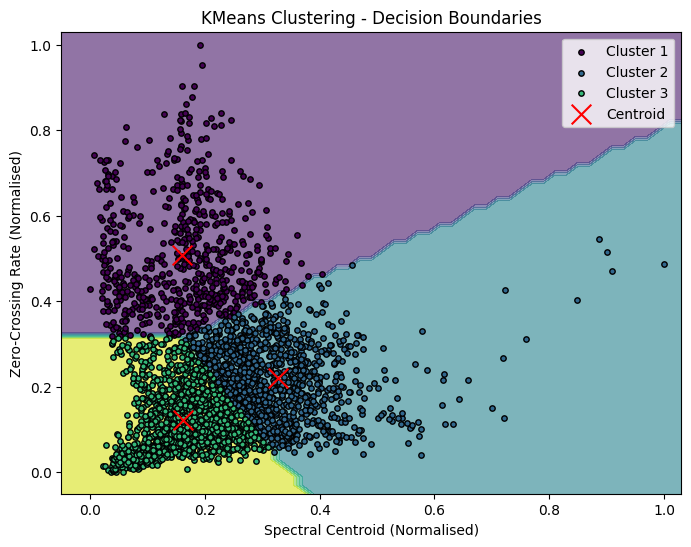

In [249]:
# Create grid of values to predict
#  Don't worry about understanding every line of code here
#  The general idea is that we need to predict the cluster at
#  every possible value of X (spectral centroid) and Y (ZCR)
#  So, we create a matrix of values uniformly sampled between ~0 and ~1
#  for every feature, and then predict at every value in this matrix
x_min, x_max = X[:, 0].min() - 0.05, X[:, 0].max() + 0.05
y_min, y_max = X[:, 1].min() - 0.05, X[:, 1].max() + 0.05
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, 0.02),
    np.arange(y_min, y_max, 0.02)
)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create the figure and set some aesthetics
plt.figure(figsize=(8, 6))
plt.xlabel('Spectral Centroid (Normalised)')
plt.ylabel('Zero-Crossing Rate (Normalised)')
plt.title('KMeans Clustering - Decision Boundaries')

# Plot the decision boundaries
plt.contourf(xx, yy, Z, alpha=0.6, cmap='viridis')

# Plot each cluster
#  We use a for loop so we can label them separately
for cluster_id in range(model.n_clusters):
    plt.scatter(
        X[model.labels_ == cluster_id, 0],
        X[model.labels_ == cluster_id, 1],
        color=plt.cm.viridis(cluster_id / model.n_clusters),
        s=15,
        edgecolor='k',
        label=f'Cluster {cluster_id + 1}'
    )

# Plot cluster centers
centroids_2d = model.cluster_centers_
plt.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    c='red',
    s=200,
    marker='x',
    label="Centroid"
)

plt.legend()
plt.show()

In the plot we just created:

- Individual points correspond with individual recordings
- The x-axis corresponds with the normalised spectral centroid
- The y-axis corresponds with the normalised zero-crossing rate
- The shaded regions on the plot correspond with the **decision boundaries** learned by the model for different clusters.
- The crosses correspond with the **centroid** of each cluster


**What can we learn from this plot?** Here are a few ideas:

1. Recordings in cluster 1 have both a low spectral centroid and zero-crossing rate
2. Several recordings in cluster 2 have a much larger spectral centroid, but still a low zero-crossing rate
3. Vice-versa, several recordings in cluster 3  have a low spectral centroid, but a much higher zero-crossing rate.

### K-Means with Higher-Dimensional Feature Space

However, there is **still quite a lot of overlap in the center of the plot** between both clusters, which suggests that these two features alone may not be adequate to fully separate the recordings.

We can try fitting the model again, but this time with our full set of 6 features. Note that this will make it a *bit harder to visualise the decision boundaries* (it's hard to plot in six dimensions at the same time!). But we can still look at the number of recordings by each instrument within every cluster.

To start with, let's train the model using the complete feature space. We'll use the same number of clusters as before (3)

In [251]:
model_full = KMeans(n_clusters=3, random_state=42, n_init="auto")
# Fit the model to the full feature space
model_full.fit(norm_feature_matrix)

KMeans(n_clusters=3, random_state=42)

Great. Now, let's take a look at the *number of recordings by each instrument* that are assigned to each cluster.

We'll start by iterating through every track in TinySOL and getting the instrument, as well as the cluster assigned by the model.

In [253]:
track_iter = list(all_recordings.values())
features_all = model_full.labels_
res = []

# Iterate through each track, with a counter
for idx, track in enumerate(track_iter):
    # Get the predicted cluster
    track_predicted_cluster = features_all[idx]
    # Get the instrument
    track_instr = track.instrument_full
    # Append everything to a list
    res.append(dict(instr=track_instr, cluster=track_predicted_cluster))



To make plotting this data a bit easier, we can use the `pandas` library. Let's convert the data into a table (which `pandas` calls a `DataFrame`).

In [255]:
df = pd.DataFrame(res)

,instr,cluster
0,Bass Tuba,2
1,Bass Tuba,2
2,Bass Tuba,2
3,Bass Tuba,2
4,Bass Tuba,2


Now, we can do the following:
- Group by each instrument
- Calculate the proportion of recordings by that instrument that fall into each cluster: 1, 2, or 3

In [279]:
proportion = (
    df.groupby("instr")["cluster"]
    .value_counts(normalize=True)
    .reset_index(drop=False)
    .sort_values(by=["cluster", "instr"])
)
proportion.columns = ["Instrument", "Cluster", "Proportion"]

Let's plot the results!

/tmp/ipython-input-296191084.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90)


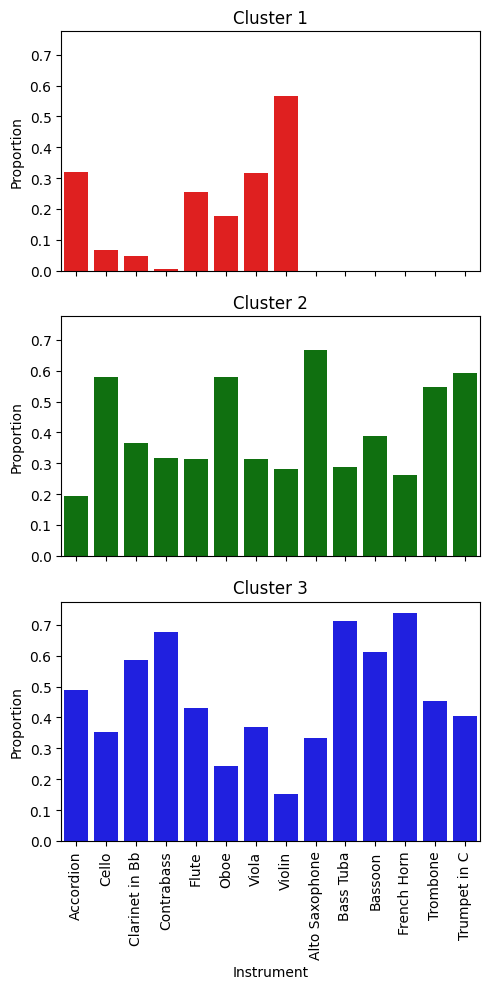

In [280]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(5, 10))
colors = ["red", "green", "blue"]
for (idx, grp), a_ in zip(proportion.groupby("Cluster"), ax.flatten()):
    sns.barplot(ax=a_, data=grp, x="Instrument", y="Proportion", color=colors[idx])
    a_.set_title(f"Cluster {idx+1}")
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()


### Interpreting Clusters

Take a look at the proportion of recordings by each instrument assigned to each cluster. **What do you notice?**

Here are some possible interpretations:

- Cluster 1 is dominated by recordings featuring stringed instruments 🎻 like the violin and viola
- Cluster 2 contains a majority of recordings by several brass 🎺 and wind 🪈 instruments, including the **trumpet**, **trombone**, **saxophone**, and **oboe**
- Cluster 3 contains **lower pitched** brass 🎺 and wind 🪈 instruments, including the **french horn**, **bassoon**, and **bass tuba**

Note, however, that most instruments contain recordings in **every cluster**. This suggests that our full feature space may not be adequate to characterise each instrument. *Why do you think this might be?*

#### Fitbit's "Sleep Animals"

> In unsupervised learning, how we interpret the clusters found by our model is **often up to us**!

A good example of this comes from **Fitbit**, a company that makes wearable smart devices like watches. They engineered ***over 1,000 features*** from sleep data provided by their users. These included features like the probability a wearer would wake up in the first hour of sleep, the mean length of their sleep cycle, and how consistent they were at waking up at the same time each night.

Then, they trained an unsupervised learning model on this data, using **6 clusters**. They assigned these clusters names based on **animals**. For instance, somebody whose "sleep animal" is a tortoise might take a long time to fall asleep, but spends longer in bed. Somebody whose animal is a giraffe, meanwhile, may experience shorter yet deeper sleep periods and earlier waking times.

> For more information, check out [Google's research blog on sleep animals.](https://blog.google/products/fitbit/fitbit-sleep-profile-animals/)

<img src="https://storage.googleapis.com/gweb-uniblog-publish-prod/images/sleep_profile_animals_hero2.width-1300.jpg" width="600px"/>



## Supervised Learning

In the previous section, we saw how unsupervised learning models tend to shine in cases where our **data is unlabelled**. But what about when we ***do*** have labels for our data? After all, we know which instrument made which recording in TinySOL!

The next type of machine learning paradigm we are going to explore is called **supervised learning**. Supervised learning is a type of machine learning where the computer learns from data that **does include the "right answers"** - in other words, each example comes with a label that tells the model what the correct output should be. The goal is for the model to learn the relationship between the input data and these labels, so it can make **accurate predictions on new, unseen data.**

For example:
- Predicting tomorrow's temperature based on past weather data
- Classifying news articles by topic (e.g. politics, sports, entertainment)
- Detecting fraudulent transactions by learning from examples of both normal and fraudulent activity

In our case, we're going to use supervised learning to train a model to **recognise which musical instrument** produced each recording in TinySOL.

### Data Splitting

Before we can start with supervised learning, we need to **split our data**.  How best to split a dataset depends on many qualities, including how it was made and the number of data points within it. For now, we're just going to split our dataset into two separate parts:
- The **training set** consists of the data points we'll use to train the model;
- The **test set** consists of the data points we'll use to evaluate how well it performs.

We need both splits of the dataset to truly understand our model: without the training split, we can't learn anything, and without the test split, we can't evaluate what we've learned.

> **Did you know?** Sometimes we may use **two separate datasets** as our training and test data. This is especially useful when **real data is hard to come by**: we can generate a large training set artificially (for instance, by using another AI model), and then evaluate performance on real-world data.

We can use `sklearn` again to split our data into training and test sets. First, let's assemble our feature set and instrument labels:

In [284]:
X = norm_feature_matrix
y = np.array([track.instrument_full for track in track_iter])
print(X.shape, y.shape)

(2913, 6) (2913,)


Now, we'll perform the split. We end up with two `X` and two `y` variables, corresponding to the training and test data, respectively.

In [313]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    test_size=0.2,
    random_state=0
)
print(f"Training feature size: {X_train.shape}")
print(f"Training label size: {y_train.shape}")
print(f"Test feature size: {X_test.shape}")
print(f"Test label size: {y_test.shape}")

Training feature size: (2330, 6)
Training label size: (2330,)
Test feature size: (583, 6)
Test label size: (583,)


Note that we used a 4:1 split, where 80% of the data ends up in the training set and 20% in the test set. This is a very common proportion split in machine learning.

Let's take a look at the number of recordings by each instrument in our splits. We'll express this as a proportion of the total number of recordings in both splits

In [314]:
names, vals = np.unique_counts(y_train)
print({str(k): float(v / sum(vals))* 100 for k, v in zip(names, vals)})

names, vals = np.unique_counts(y_test)
print({str(k): float(v / sum(vals)) * 100 for k, v in zip(names, vals)})

{'Accordion': 22.489270386266096, 'Alto Saxophone': 3.347639484978541, 'Bass Tuba': 3.9055793991416308, 'Bassoon': 4.291845493562231, 'Cello': 10.042918454935622, 'Clarinet in Bb': 4.291845493562231, 'Contrabass': 11.158798283261802, 'Flute': 3.9484978540772535, 'French Horn': 4.592274678111588, 'Oboe': 3.9055793991416308, 'Trombone': 3.9055793991416308, 'Trumpet in C': 3.4763948497854082, 'Viola': 10.557939914163091, 'Violin': 10.085836909871244}
{'Accordion': 28.30188679245283, 'Alto Saxophone': 3.6020583190394513, 'Bass Tuba': 2.9159519725557463, 'Bassoon': 4.459691252144083, 'Cello': 9.777015437392796, 'Clarinet in Bb': 4.459691252144083, 'Contrabass': 8.404802744425385, 'Flute': 4.459691252144083, 'French Horn': 4.631217838765009, 'Oboe': 2.7444253859348198, 'Trombone': 4.459691252144083, 'Trumpet in C': 2.5728987993138936, 'Viola': 10.806174957118353, 'Violin': 8.404802744425385}


#### Stratified Splitting

That's interesting: 28% of the recordings in our test data feature the **Accordion**, but only 22% of those in the training data feature this instrument. If our dataset was **very unbalanced**, this could be a problem.

For example, imagine we were building a model to predict whether a patient has a certain disease, but **95%** of the training data are healthy patients and only **5%** have the disease. Without careful handling, the model might just predict “healthy” for everyone, since it sees **so few examples of the disease.**

To accomodate this, we may want to **stratify** our data splits. This will keep the number of recordings per class approximately equal across both splits:

In [316]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    test_size=0.2,
    random_state=42,
    stratify=y
)
names, vals = np.unique_counts(y_train)
print({str(k): float(v / sum(vals))* 100 for k, v in zip(names, vals)})

names, vals = np.unique_counts(y_test)
print({str(k): float(v / sum(vals)) * 100 for k, v in zip(names, vals)})

{'Accordion': 23.6480686695279, 'Alto Saxophone': 3.3905579399141628, 'Bass Tuba': 3.6909871244635193, 'Bassoon': 4.334763948497854, 'Cello': 10.0, 'Clarinet in Bb': 4.334763948497854, 'Contrabass': 10.600858369098711, 'Flute': 4.034334763948498, 'French Horn': 4.592274678111588, 'Oboe': 3.6909871244635193, 'Trombone': 4.034334763948498, 'Trumpet in C': 3.304721030042918, 'Viola': 10.600858369098711, 'Violin': 9.742489270386265}
{'Accordion': 23.67066895368782, 'Alto Saxophone': 3.430531732418525, 'Bass Tuba': 3.7735849056603774, 'Bassoon': 4.288164665523156, 'Cello': 9.948542024013722, 'Clarinet in Bb': 4.288164665523156, 'Contrabass': 10.634648370497427, 'Flute': 4.1166380789022305, 'French Horn': 4.631217838765009, 'Oboe': 3.6020583190394513, 'Trombone': 3.9451114922813035, 'Trumpet in C': 3.2590051457975986, 'Viola': 10.634648370497427, 'Violin': 9.777015437392796}


Much better: after stratification, we can see that the proportion of recordings by each instrument is **roughly the same** across both training and test data.

#### Data Leakage

One of the most common mistakes by students when learning machine learning is **data leakage**. This is when data used to train the model is accidentally used to evaluate it, as well.

> Imagine if you were studying for a maths exam, and somehow the exam questions were included in your study guide. You might score perfectly, but it wouldn't reflect your true understanding of maths - you just memorised the answers in advance.

Data leakage works the same way in machine learning. Luckily, `sklearn` handles data splitting in such a way that prevents leakage. However, we can check our dataset to ensure that no feature vector in the training set also appears in the test set:

In [305]:
for row in X_train:
    assert row not in X_test, f"Found {row} in test data!"

The `for` loop written above will test each row of the training data to make sure that it doesn't appear in the test data.

> Try replacing `X_train` with `X_test` to see it break!

#### Alternative Data Splitting Methods

Splitting into separate training and test data is perhaps the simplest way of splitting a dataset. There are many alternatives, including:

- $k$-fold **cross validation**: rather than obtaining only one training and test dataset, we obtain **k** training and test datasets. We usually average the performance of our model over all test datasets. This means that, if our model performs very well (or very badly) on one test dataset, this won't inflate the results overall.
- **train-validation-test**: this involves splitting our test data again into two separate splits, called the **validation** and **test** data. During training, we check our performance on the validation data: once we've finished training, we evaluate the model for the final time on the test data. This is especially common when training **deep learning** models.

### Supervised Learning with k-Nearest Neighbours

One of the simplest and most intuitive supervised learning models is k-Nearest Neighbours (kNN).

> **Important**: don't confuse this with **k-Means Clustering** from the previous section: they are **different models**.

Imagine you move to a new city and want to find restaurants you'll like. Instead of trying to understand every cuisine in town, you ask about the restaurants your closest friends enjoy. If most of your friends love a particular place, you're likely to enjoy it too. Similarly, k-NN makes predictions based on the "nearest" examples in the data - looking at the labels of similar instances to decide the label of a new one.

Mathematically, k-NN uses the feature vector assigned to each data point. When predicting this point's label, it computes the **distance** between this point and all points in the training set. Then, it selects the $k$ closest points from the training data (hence, k-nearest neighbours!). The predicted label is typically the majority label among these neighbours.

<img src="https://trendspider.com/learning-center/wp-content/uploads/2024/08/K-Nearest-Neighbors-KNN.png" width="600px"/>




#### Train the Model

Again, we'll use `sklearn` to train the k-NN model.

The syntax looks largely the same as the unsupervised learning model. The difference is that we have to pass two values into the `.fit` function: one for our features, and another for our labels.

In [317]:
supervised_model = KNeighborsClassifier(n_neighbors=5)
supervised_model.fit(X_train, y_train)

KNeighborsClassifier()

#### Evaluate the Model

Let's take a look at how well our model performs on the test data. In this case, we can simply consider how **accurate** it is. The process looks a bit like this:
- For every recording in the test data, we predict the instrument
- We assign a score of 1 for that recording if we got it right, and 0 if we got it wrong
- Finally, we average all of our scores to compute the overall accuracy.

In [321]:
# Predict labels for the test data
y_pred = supervised_model.predict(X_test)
# Compute the accuracy
acc = accuracy_score(y_test, y_pred)
print(acc * 100)

68.61063464837049


Great! We can see that our model is 68% accurate when predicting the instrument in a recording.

Let's put that into context by just computing the accuracy of guessing the instrument randomly. For every recording in the test data, we'll randomly predict an instrument, and then compute the baseline accuracy using those predictions.

In [324]:
y_rand = [np.random.choice(y) for _ in range(len(y_pred))]
acc = accuracy_score(y_test, y_rand)
print(acc * 100)

11.320754716981133


OK: so, randomly predicting the instrument means that we're only correct 11% of the time. This means that our machine learning model is **over six times better than chance**.

> **Important**: there are many different ways to **evaluate** a supervised learning model, accuracy being just one example. In the next notebook, we'll look at other possible evaluation metrics.

### Supervised Learning with a Neural Network

We've just seen how a very simple supervised learning classifier can achieve impressive performance when identifying instruments from audio recordings. But, when we think about machine learning in the real world, the majority of the models tend not to be this simple! Since the late 2010s, **neural networks** have become the *defacto* choice for many (but not all) machine learning tasks.

These models are inspired by the way the **human brain works**. They consist of layers of neurons, where each neuron takes in numbers, does a little calculation, and passes the result to the next layer. By adjusting the connections between neurons during training, the network learns to recognize patterns in data - like which sounds belong to which instrument - and can make predictions on new, unseen examples.

<img src="https://clevertap.com/wp-content/uploads/2019/04/Neural_Network_Brain_Mimic.jpeg" width="600px"/>

#### Network Architecture

We're now going to build a simple neural network to **identify the musical instruments** in TinySOL. Our network will have a single linear and a single softmax layer.

Let's explore each of them in turn.

#### Linear Layer

One of the foundational building blocks of a neural network is a **linear layer** (sometimes also called a **fully connected** or **dense** layer).

The linear layer takes in a feature vector, multiplies it by a **weight matrix**, and adds a **bias vector**. Essentially, this results in a weighted **sum** of the input features. This allows the network to **combine and transform input features** in ways that help it learn patterns in the data.

Mathematically, a linear layer looks a little like:

$y = Wx + B$

where $W$ is our weight matrix, $x$ is our feature vector, and $B$ is our bias term. The shape of the weight matrix is `(out_features, in_features)`, and the shape of the bias term is `(out_features,)`.

> The shape of $x$ is, of course, `(in_features,)`

During training, we **update** the values within $W$ and $B$ so as to **minimize the probability** of identifying the incorrect class. We'll cover this process in more detail later on.

#### Softmax Layer

In many supervised learning models, the final layer is often called a **classification head**. The classification head has two parts: a linear layer, and a softmax layer.


This takes in the final feature vector and passes it in to a **linear layer**, with the number of output features set to the number of **target classes to predict**.

The output of the linear layer is thus a vector where each value corresponds with one of our **target classes**. The individual values in this vector are known as **logits**, and they are **unbounded** - they can take any numerical value.

We then usually pass these logits into a final layer, called a **softmax** layer. The softmax layer **rescales** the logits so that they lie in the range `[0, 1]`, and that they **sum to `1`**.

The effect of this is that, after passing a feature vector through the classification head, we can interpret each number as the **predicted probability of the input being each class**.

#### Building the Network

OK, that's enough theory: let's try building the network. We're going to use the `pytorch` library, which is a very common library for building, training, and evaluating neural networks.

Models in `pytorch` use Python `classes`. They inherit from the parent class `torch.nn.Module` and must define two methods: `__init__` and `forward`. We'll discuss them more in the code snippet.

In [ ]:
class SimpleInstrumentClassifier(torch.nn.Module):
    """
    A simple musical instrument classifier built in PyTorch.

    The model contains one linear layer to generate logits
    from an input feature vector, and one softmax layer to
    convert these logits into class probabilities.
    """

    def __init__(self, in_features: int, out_classes: int):
        """
        The __init__ method initialises the model.

        Inside it, we define the layers we want to use in the
        model, as well as the shape that they should take.

        Here, we define the number of input features that our
        linear layer should take in, and the number of output
        classes it should predict.

        Note that the softmax layer does not take in any arguments.
        """

        self.fc = torch.nn.Linear(in_features, out_classes)
        self.softmax = torch.nn.Softmax()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        The .forward method defines the "forward pass".

        It takes in the raw feature vector, passes it through
        all the layers of the model, and returns the output.
        """
        logits = self.fc(x)
        proba = self.softmax(logits)
        return proba

#### Passing Data to the Model

When we trained our `sklearn` models, we were able to train using every feature for every recording at once. This worked fine, because `KNeihgborsClassifier` is not particularly computationally intense.

But, as we start training larger and larger deep neural networks, we usually can't fit our entire dataset into the memory of our computer at the same time. Instead, we usually use a process called **batch learning**, where we train on smaller **subsets** of our dataset.

In `pytorch`, a `DataLoader` is used to split our full dataset into batches. We can directly specify the number of recordings in every batch using the `batch_size` parameter.

We'll create one `DataLoader` for the training and test splits of our dataset:

In [340]:
# This mapping converts our instrument names from strings to integers
str_to_int_mapping = {k: v for v, k in enumerate(np.unique(y))}

# Create the dataloaders
train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_train),
        torch.tensor([str_to_int_mapping[yt] for yt in y_train])
    ),
    batch_size=32,
)
test_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test),
        torch.tensor([str_to_int_mapping[yt] for yt in y_test])
    ),
    batch_size=32,
)

#### Loss Functions and Optimizers

We've now got (nearly) everything in place to start training our neural network. The last pieces of the puzzle are our **loss function** and **optimizer**.

The **loss function** measures how wrong the network's predictions are compared to the true answers. It gives the model a number to aim to minimize during training - the smaller the loss, the better the predictions.

There are many different loss functions we could use. For classification problems, one of the most common is the **cross-entropy loss**, which works hand-in-hand with the outputs of our **softmax layer**.

As we saw earlier, the **softmax layer** turns the network's raw outputs into **probabilities** for each class. The cross-entropy loss then measures how far these predicted probabilities are from the true labels.

Again, we can use the implementation of cross-entropy from `pytorch`:

In [ ]:
cce_loss = torch.nn.NLLLoss()

The optimizer is like a guide that **adjusts the network's weight and bias terms** to reduce the loss. It decides how much and in which direction each weight should change, helping the model gradually improve and learn the patterns in the data.

Again, there are many different optimizers available in `torch`. For now, we'll stick with the `Adam` optimizer, which is one of the most popular.

When we define

In [341]:
optimizer = torch.nn.optim.Adam(lr=1e-4)

AttributeError: module 'torch.nn' has no attribute 'Adam'